In [1]:
## pyspark imports 
import pyspark 
from pyspark import SparkContext
from pyspark.ml.feature import CountVectorizer, PCA, StopWordsRemover, IDF, RegexTokenizer
from pyspark.sql import SparkSession

## others 
import re 
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
SparkContext.setSystemProperty('spark.executor.memory','2g')
sc = pyspark.SparkContext('local[*]')

In [3]:
spark = SparkSession\
    .builder\
    .appName("CountVectorizerExample")\
    .getOrCreate()

In [4]:
pub_rdd = sc.textFile("publications.txt")

In [5]:
small_pub_rdd = pub_rdd.sample(False, 1e-3)
small_pub_rdd.count()

20897

### I am only using a subset of the data because it cannot run in my computer on the full data: 
### to use the full data you can replace small_pub_rdd in the line below by pub_rdd

In [6]:
small_titles_full = small_pub_rdd.filter(
                lambda l: re.match('^#\*(.*)', l)).map(
                lambda l: re.match('^#\*(.*)', l).group(1).strip()).filter(
                lambda l: l != "").map(lambda l: (0, l.lower()))

In [7]:
small_titles_df = small_titles_full.toDF()

In [8]:
small_titles_df.show()

+---+--------------------+
| _1|                  _2|
+---+--------------------+
|  0|kooperation in kl...|
|  0|natürlichsprachli...|
|  0|logic programming...|
|  0|network database ...|
|  0|a new approach to...|
|  0|extracting optima...|
|  0|design, developme...|
|  0|challenges of usi...|
|  0|generation of geo...|
|  0|parallel processi...|
|  0|a service retriev...|
|  0|a graph theory ba...|
|  0|a study of reconf...|
|  0|multi-tier data a...|
|  0|on the difficulty...|
|  0|relational learni...|
|  0|bootstrapping tra...|
|  0|piecewise linear ...|
|  0|a strategy for ml...|
|  0|the use of object...|
+---+--------------------+
only showing top 20 rows



In [9]:
def apply_count_vectorizer(df, vs=1000, ic="words", oc="features"): 
    """
    transforms the words to the count vectorized format 
    """
    cv = CountVectorizer(inputCol=ic, outputCol=oc, vocabSize=vs)
    model = cv.fit(df)
    result = model.transform(df)
    
    return (result, model)


def apply_pca(df, reduced_dim=50, ic="features", oc="pcaFeatures"): 
    """
    reduces the dimentionality of the feature vectors 
    """
    pca = PCA(k=50, inputCol=ic, outputCol=oc)
    model = pca.fit(df)
    result = model.transform(df)
    
    return (result, model)


def remove_stop_words(df, sw_file="stopwords_english.txt", ic="words"): 
    """
    """
    filter_words = sc.textFile("stopwords_english.txt").collect()
    remover = StopWordsRemover(inputCol=ic, outputCol="filtered", stopWords=filter_words)
    new_df = remover.transform(df)
    
    return new_df


def apply_tf_idf(df, ic="features", k=1000, oc="tfidFeatures"): 
    """
    """
    idf = IDF(inputCol=ic, outputCol=oc)
    idfModel = idf.fit(df)
    rescaledData = idfModel.transform(df)
    
    return (rescaledData, idfModel) 

def plot_scatter(fv, ids=False, color=['purple'], ic="features"): 
    """
    """
    pca_result, pca_model = apply_pca(fv, reduced_dim=2, ic=ic)
    if not ids: 
        pca_features = pca_result.select("pcaFeatures").rdd.map(lambda r: r[0])
        x_s = pca_features.map(lambda l: l[0]).collect()
        y_s = pca_features.map(lambda l: l[1]).collect()
        plt.scatter(x=x_s,y=y_s,c=color, alpha=0.5)
    else: 
        pca_features_0 = pca_result.select("_1", "pcaFeatures").rdd.filter(lambda r: r[0] == 0)
        pca_features_1 = pca_result.select("_1", "pcaFeatures").rdd.filter(lambda r: r[0] == 1)
        
        x_0 = pca_features_0.map(lambda l: l[1][0]).collect()
        y_0 = pca_features_0.map(lambda l: l[1][1]).collect()
        
        x_1 = pca_features_1.map(lambda l: l[1][0]).collect()
        y_1 = pca_features_1.map(lambda l: l[1][1]).collect()
        
        plt.scatter(x=x_0,y=y_0, c=['yellow'], alpha=0.5)
        plt.scatter(x=x_1,y=y_1, c=['blue'], alpha=0.5)
 
        
def part_c(pca_model, vocab_model):
    """
    """
    vocab = vocab_model.vocabulary
    eigenvectors = pca_model.pc.toArray().T
    for k,ev in enumerate(eigenvectors):
        ws = [vocab[w] for (w,c) in enumerate(np.abs(ev)) if c > 0.2]
#         print(k, (ev**2).sum())
        print(k,ws)

In [10]:
##### all the required data frames for the first part 

regexTokenizer = RegexTokenizer(inputCol="_2", outputCol="words", pattern="\\W")
df_small_titles_full = regexTokenizer.transform(small_titles_df)
df_small_titles_full.show()

+---+--------------------+--------------------+
| _1|                  _2|               words|
+---+--------------------+--------------------+
|  0|kooperation in kl...|[kooperation, in,...|
|  0|natürlichsprachli...|[nat, rlichsprach...|
|  0|logic programming...|[logic, programmi...|
|  0|network database ...|[network, databas...|
|  0|a new approach to...|[a, new, approach...|
|  0|extracting optima...|[extracting, opti...|
|  0|design, developme...|[design, developm...|
|  0|challenges of usi...|[challenges, of, ...|
|  0|generation of geo...|[generation, of, ...|
|  0|parallel processi...|[parallel, proces...|
|  0|a service retriev...|[a, service, retr...|
|  0|a graph theory ba...|[a, graph, theory...|
|  0|a study of reconf...|[a, study, of, re...|
|  0|multi-tier data a...|[multi, tier, dat...|
|  0|on the difficulty...|[on, the, difficu...|
|  0|relational learni...|[relational, lear...|
|  0|bootstrapping tra...|[bootstrapping, t...|
|  0|piecewise linear ...|[piecewise, li

## Start of application: 
### part a. truncating to 1000 most fequent words using count_vector

In [11]:
count_vect_result, count_vec_model = apply_count_vectorizer(df_small_titles_full)  
count_vect_result.show()

+---+--------------------+--------------------+--------------------+
| _1|                  _2|               words|            features|
+---+--------------------+--------------------+--------------------+
|  0|kooperation in kl...|[kooperation, in,...|    (1000,[4],[1.0])|
|  0|natürlichsprachli...|[nat, rlichsprach...|  (1000,[713],[1.0])|
|  0|logic programming...|[logic, programmi...|(1000,[49,54,72,7...|
|  0|network database ...|[network, databas...|(1000,[19,24,83,1...|
|  0|a new approach to...|[a, new, approach...|(1000,[2,3,4,9,23...|
|  0|extracting optima...|[extracting, opti...|(1000,[113,116,29...|
|  0|design, developme...|[design, developm...|(1000,[0,2,3,19,5...|
|  0|challenges of usi...|[challenges, of, ...|(1000,[0,1,11,180...|
|  0|generation of geo...|[generation, of, ...|(1000,[0,6,7,11,8...|
|  0|parallel processi...|[parallel, proces...|(1000,[2,3,4,58,6...|
|  0|a service retriev...|[a, service, retr...|(1000,[2,7,8,14,5...|
|  0|a graph theory ba...|[a, grap

### applying PCA 

In [12]:
pca_result, pca_model = apply_pca(count_vect_result)
pca_result.show()

+---+--------------------+--------------------+--------------------+--------------------+
| _1|                  _2|               words|            features|         pcaFeatures|
+---+--------------------+--------------------+--------------------+--------------------+
|  0|kooperation in kl...|[kooperation, in,...|    (1000,[4],[1.0])|[-0.0989193539552...|
|  0|natürlichsprachli...|[nat, rlichsprach...|  (1000,[713],[1.0])|[-0.0020234612000...|
|  0|logic programming...|[logic, programmi...|(1000,[49,54,72,7...|[0.00317377634847...|
|  0|network database ...|[network, databas...|(1000,[19,24,83,1...|[-0.0405839216641...|
|  0|a new approach to...|[a, new, approach...|(1000,[2,3,4,9,23...|[-0.3847273147156...|
|  0|extracting optima...|[extracting, opti...|(1000,[113,116,29...|[0.00554833550270...|
|  0|design, developme...|[design, developm...|(1000,[0,2,3,19,5...|[-1.1085114654349...|
|  0|challenges of usi...|[challenges, of, ...|(1000,[0,1,11,180...|[-0.6019557169415...|
|  0|gener

[0.0570363266546,0.0405990535718,0.0339737683624,0.0315615988861,0.0267142152334,0.0241389865495,0.0196408160465,0.0130380815092,0.0125885434719,0.0120605744047,0.0105454444962,0.00973873745356,0.00922064914061,0.00809653233914,0.00755741383228,0.00747012161552,0.00649873450051,0.00618078222617,0.00563008700454,0.00551505757175,0.00540463590326,0.00516909136556,0.00493173119704,0.00487979495054,0.00452712426244,0.00451359728802,0.00438828546201,0.00430034460163,0.00424429858426,0.00410484486465,0.0039976837316,0.00390972562843,0.003766928071,0.00376035416181,0.00357929929944,0.0035185745712,0.0034975526544,0.00337896982868,0.00335662907748,0.00329013153203,0.00324658606909,0.00320923474817,0.00314898875043,0.00310318390383,0.00304783990471,0.00302564831152,0.0029880589958,0.00292755329924,0.00289899549472,0.00287871079764]


array([[ -8.23392417e-01,  -1.30754936e-01,   6.18239752e-02, ...,
          1.23047933e-03,   1.26614887e-04,  -1.25275791e-02],
       [  2.10807585e-01,  -5.41558493e-01,  -1.65264080e-01, ...,
         -1.25224006e-02,  -2.56590505e-03,   1.51439257e-02],
       [ -7.91550293e-02,  -7.48661657e-01,  -1.73031875e-01, ...,
         -8.54301080e-04,   4.03102171e-03,   2.51502405e-02],
       ..., 
       [ -4.00948936e-04,  -1.02292425e-03,   1.10519515e-03, ...,
          9.15375807e-03,   2.00405163e-03,  -3.94076186e-03],
       [  1.95477500e-04,   2.01819774e-03,  -1.96731148e-03, ...,
          1.76018858e-03,  -3.22350899e-03,  -2.51873724e-03],
       [ -8.14039018e-04,  -1.01250100e-03,  -3.61834900e-04, ...,
         -1.61015135e-03,  -1.16845030e-02,   3.16058508e-03]])

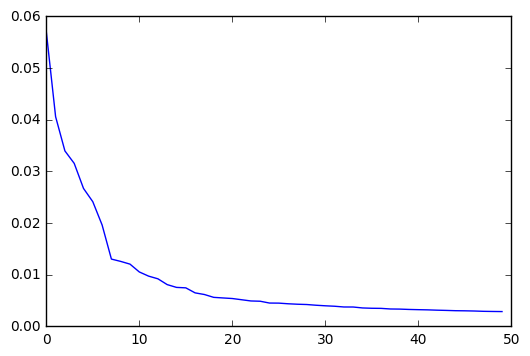

In [13]:
## checkes the variance across differenbt features 
var = pca_model.explainedVariance
print(var)
np.shape(var)

plt.plot(var)
pca_model.pc.toArray()

### as we can see below, we need 6 components to explain 50% of the total variance 

[ 0.12377677  0.21188237  0.28561018  0.35410324  0.41207681  0.46446177
  0.50708508  0.53537953  0.56269842  0.58887155  0.61175663  0.63289105
  0.65290114  0.67047175  0.68687239  0.70308359  0.71718675  0.73059991
  0.74281798  0.75478642  0.76651524  0.77773288  0.78843543  0.79902526
  0.80884975  0.81864489  0.82816808  0.83750042  0.84671114  0.85561923
  0.86429476  0.87277941  0.88095417  0.88911466  0.89688224  0.90451803
  0.91210821  0.91944104  0.9267254   0.93386544  0.94091098  0.94787547
  0.95470921  0.96144356  0.96805779  0.97462387  0.98110837  0.98746157
  0.9937528   1.        ]


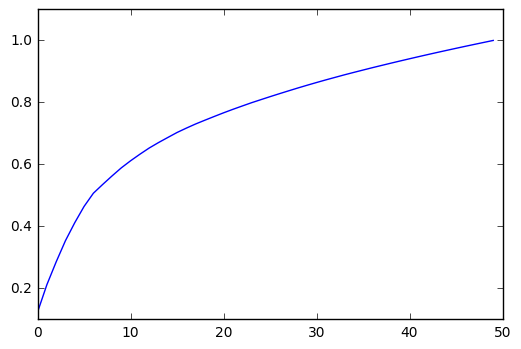

In [14]:
print(np.cumsum(var)/np.sum(var))
plt.plot(np.cumsum(var)/np.sum(var))

### Identifying important words in each of the principle components

In [15]:
part_c(pca_model, count_vec_model)

0 ['of', 'for', 'the']
1 ['for', 'a', 'and']
2 ['and', 'the']
3 ['for', 'a', 'in', 'the']
4 ['of', 'for', 'in', 'the']
5 ['of', 'in', 'the', 'on']
6 ['in', 'the', 'on', 'based']
7 ['based', 'to', 'an', 'approach']
8 ['on', 'based', 'with']
9 ['on', 'based', 'with', 'an']
10 ['with', 'to', 'an', 'using', 'systems']
11 ['using', 'systems', 'networks']
12 ['to', 'an', 'using', 'systems']
13 ['an', 'system', 'model']
14 ['systems', 'system', 'model', 'networks', 'wireless']
15 ['model', 'networks', 'data']
16 ['model', 'information', 'data']
17 ['analysis', 'information', 'data']
18 ['information', 'time', 'multi', 'real']
19 ['analysis', 'information', 'design', 'time']
20 ['analysis', 'information', 'design']
21 ['time', 'multi', 'network']
22 ['design', 'by', 'multi', 'network', 'learning']
23 ['by', 'multi', 'network']
24 ['from', 'software', 'web', 'mobile', '2008', 'isbn', 'pp', 'press']
25 ['design', 'approach', 'network', 'algorithm', 'performance', 'study', 'software']
26 ['learni

## Scatter plot of initial results

The scatter plot of the results of count vectorizer before filtering the stop words is unstructured because as we can see in part c (above) these stop words are the words most frequently occuring and they should not be carrying alot of weight. Two components capture 21% of the variance which means that there are more grouping and less structure because less data is more spread out from the mean. 

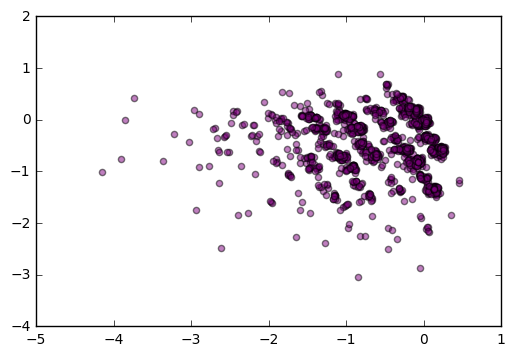

In [16]:
plot_scatter(count_vect_result)

## preprocessing and removing stop words


In [17]:
filtered_df = remove_stop_words(df_small_titles_full)
filtered_df.show()

+---+--------------------+--------------------+--------------------+
| _1|                  _2|               words|            filtered|
+---+--------------------+--------------------+--------------------+
|  0|kooperation in kl...|[kooperation, in,...|[kooperation, kle...|
|  0|natürlichsprachli...|[nat, rlichsprach...|[nat, rlichsprach...|
|  0|logic programming...|[logic, programmi...|[logic, programmi...|
|  0|network database ...|[network, databas...|[network, databas...|
|  0|a new approach to...|[a, new, approach...|[new, approach, h...|
|  0|extracting optima...|[extracting, opti...|[extracting, opti...|
|  0|design, developme...|[design, developm...|[design, developm...|
|  0|challenges of usi...|[challenges, of, ...|[challenges, usin...|
|  0|generation of geo...|[generation, of, ...|[generation, geom...|
|  0|parallel processi...|[parallel, proces...|[parallel, proces...|
|  0|a service retriev...|[a, service, retr...|[service, retriev...|
|  0|a graph theory ba...|[a, grap

In [18]:
count_vect_fw_result, cv_fw_model = apply_count_vectorizer(filtered_df, ic="filtered")
count_vect_fw_result.show()

+---+--------------------+--------------------+--------------------+--------------------+
| _1|                  _2|               words|            filtered|            features|
+---+--------------------+--------------------+--------------------+--------------------+
|  0|kooperation in kl...|[kooperation, in,...|[kooperation, kle...|        (1000,[],[])|
|  0|natürlichsprachli...|[nat, rlichsprach...|[nat, rlichsprach...|  (1000,[599],[1.0])|
|  0|logic programming...|[logic, programmi...|[logic, programmi...|(1000,[43,45,59,6...|
|  0|network database ...|[network, databas...|[network, databas...|(1000,[9,13,71,90...|
|  0|a new approach to...|[a, new, approach...|[new, approach, h...|(1000,[12,44,56,6...|
|  0|extracting optima...|[extracting, opti...|[extracting, opti...|(1000,[103,273,89...|
|  0|design, developme...|[design, developm...|[design, developm...|(1000,[9,40,65,14...|
|  0|challenges of usi...|[challenges, of, ...|[challenges, usin...|(1000,[1,160,243,...|
|  0|gener

In [19]:
pca_result_2, pca_model_2 = apply_pca(count_vect_fw_result)
pca_result_2.show(truncate=True)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| _1|                  _2|               words|            filtered|            features|         pcaFeatures|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|kooperation in kl...|[kooperation, in,...|[kooperation, kle...|        (1000,[],[])|[0.0,0.0,0.0,0.0,...|
|  0|natürlichsprachli...|[nat, rlichsprach...|[nat, rlichsprach...|  (1000,[599],[1.0])|[0.00323414530613...|
|  0|logic programming...|[logic, programmi...|[logic, programmi...|(1000,[43,45,59,6...|[-0.0058368289803...|
|  0|network database ...|[network, databas...|[network, databas...|(1000,[9,13,71,90...|[-0.0103117898587...|
|  0|a new approach to...|[a, new, approach...|[new, approach, h...|(1000,[12,44,56,6...|[-0.0218262128813...|
|  0|extracting optima...|[extracting, opti...|[extracting, opti...|(1000,[103,273,89...|[0.00483875739402...|
|

[0.0213075399461,0.0140985201938,0.0131242287002,0.011939088556,0.0107850016404,0.0103854941154,0.00894065539493,0.00866581528303,0.00798721108458,0.00779795162366,0.00747518118963,0.00716828537592,0.00688023426238,0.00657733534686,0.00641484119332,0.00633061050855,0.00606555852237,0.00602145731786,0.0058020279688,0.00559997882905,0.00532980299371,0.00523128390277,0.00504493111458,0.00493726337966,0.00492166350615,0.00475583120633,0.00470152046501,0.00458889577443,0.00455231306193,0.00445395707517,0.00438542436826,0.00435003899982,0.00431012845032,0.00419565679518,0.00417123428315,0.00409713173635,0.00407431851779,0.0040203190557,0.00396476745722,0.0039194650352,0.0038773379528,0.00374834459123,0.00369656051982,0.00367873503092,0.00364980412868,0.00363423598421,0.00356472818027,0.00353271133312,0.00349101850692,0.00347039502836]


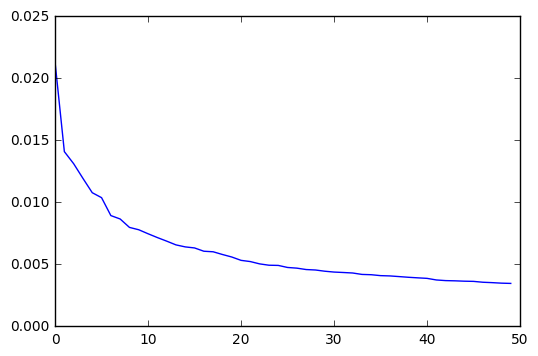

In [20]:
## checkes the variance across different features 
var = pca_model_2.explainedVariance
print(var)
np.shape(var)
plt.plot(var)

### as we can see below, we need 15 components to explain 50% of the total variance

[ 0.06969698  0.11581325  0.15874261  0.19779538  0.23307313  0.26704409
  0.29628898  0.32463487  0.35076104  0.37626814  0.40071947  0.42416694
  0.44667219  0.46818666  0.48916961  0.50987704  0.52971748  0.54941368
  0.56839211  0.58670965  0.60414344  0.62125497  0.63775695  0.65390674
  0.6700055   0.68556183  0.70094051  0.71595079  0.73084141  0.7454103
  0.75975503  0.77398401  0.78808245  0.80180644  0.81545055  0.82885227
  0.84217937  0.85532984  0.8682986   0.88111917  0.89380195  0.90606278
  0.91815424  0.93018738  0.94212589  0.95401348  0.96567371  0.97722921
  0.98864834  1.        ]


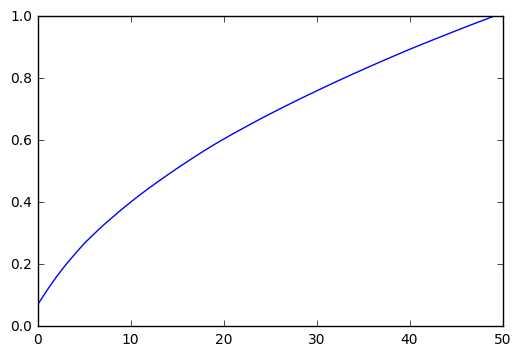

In [21]:
print(np.cumsum(var)/np.sum(var))
plt.plot(np.cumsum(var)/np.sum(var))

### Identifying important words in each of the principle components after filtering out stop words 

In [22]:
part_c(pca_model_2, cv_fw_model)

0 ['based']
1 ['using', 'systems']
2 ['using', 'systems']
3 ['system', 'model', 'networks', 'information']
4 ['system', 'networks', 'wireless']
5 ['system', 'model', 'data']
6 ['model', 'analysis', 'information', 'data', 'time']
7 ['analysis', 'information', 'data', 'performance']
8 ['analysis', 'information', 'data', 'design']
9 ['information', 'design', 'time', 'multi', 'real']
10 ['analysis', 'information', 'design', 'time']
11 ['information', 'time', 'multi', 'network']
12 ['design', 'multi', 'network', 'algorithm']
13 ['approach', 'network', 'performance', 'study']
14 ['design', 'approach', 'study', 'software', 'case', 'object', 'oriented']
15 ['web', 'mobile', '2008', 'isbn', 'press', 'pp']
16 ['learning', 'algorithm']
17 ['approach', 'learning', 'algorithm', 'performance', 'software']
18 ['network', 'learning', 'algorithm', 'performance']
19 ['algorithm', 'software', 'web']
20 ['learning', 'performance', 'study', 'evaluation', 'case', 'object']
21 ['control', 'adaptive']
22 ['so

## Scatter plot of count vectorizer results after removing stop words

as we can see below, after we remove the stop words, we get a stuctured scatter plot and similar components appear in the same grouping because only relevant words are being weighted in the principle components as we can see in part c above. Two components capture 11% of the variance which means that there are less grouping and better structure because less data is less spread out from the mean. 

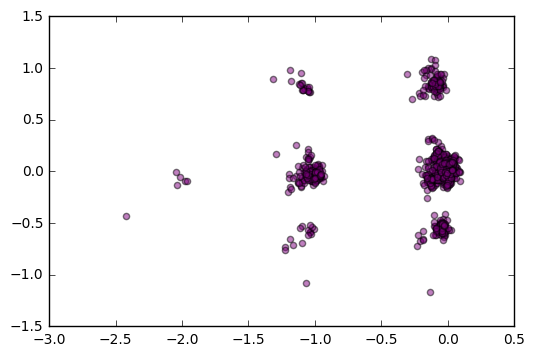

In [23]:
plot_scatter(count_vect_fw_result)

## TF-IDF

In [24]:
tfResult, tfmodel = apply_tf_idf(count_vect_fw_result)
tfResult.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| _1|                  _2|               words|            filtered|            features|        tfidFeatures|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|kooperation in kl...|[kooperation, in,...|[kooperation, kle...|        (1000,[],[])|        (1000,[],[])|
|  0|natürlichsprachli...|[nat, rlichsprach...|[nat, rlichsprach...|  (1000,[599],[1.0])|(1000,[599],[5.88...|
|  0|logic programming...|[logic, programmi...|[logic, programmi...|(1000,[43,45,59,6...|(1000,[43,45,59,6...|
|  0|network database ...|[network, databas...|[network, databas...|(1000,[9,13,71,90...|(1000,[9,13,71,90...|
|  0|a new approach to...|[a, new, approach...|[new, approach, h...|(1000,[12,44,56,6...|(1000,[12,44,56,6...|
|  0|extracting optima...|[extracting, opti...|[extracting, opti...|(1000,[103,273,89...|(1000,[103,273,89...|
|

In [25]:
idf_pca_result, idf_pca_model = apply_pca(tfResult, ic="tfidFeatures")
idf_pca_result.select(["_1", "pcaFeatures"]).show()

+---+--------------------+
| _1|         pcaFeatures|
+---+--------------------+
|  0|[0.0,0.0,0.0,0.0,...|
|  0|[0.70179604335518...|
|  0|[0.12534134716536...|
|  0|[-0.0529180964690...|
|  0|[-0.0172915510677...|
|  0|[0.00916881951923...|
|  0|[-0.0440493098306...|
|  0|[-0.0631131307460...|
|  0|[-0.1189184238070...|
|  0|[0.00238497281612...|
|  0|[-0.1767840548228...|
|  0|[-0.0369277085729...|
|  0|[-0.0732126116020...|
|  0|[-0.1576655223987...|
|  0|[-0.0097353121865...|
|  0|[0.12503992665816...|
|  0|[-0.0378521999790...|
|  0|[-0.0464777114545...|
|  0|[-0.0099947677620...|
|  0|[0.27651475818713...|
+---+--------------------+
only showing top 20 rows



In [26]:
var = idf_pca_model.explainedVariance
print(var)
np.shape(var)

[0.00887728203989,0.00597388659684,0.00570271888676,0.00540842892752,0.00518600516194,0.00488709444652,0.00484090701586,0.00459779565076,0.00452426977422,0.00450068539938,0.00444210117148,0.00436198308512,0.00430376959508,0.00421910388237,0.00416061117908,0.00412273165082,0.00402640867289,0.00397440553443,0.00391772352952,0.00386747088978,0.00381153296621,0.00380857068616,0.00375747563333,0.00370639936031,0.0036670003537,0.00363972103027,0.00363353340736,0.00359746103137,0.00353496083172,0.00347735454666,0.00346810907524,0.0034408066675,0.00340116917994,0.00337973287032,0.00332395808053,0.00329010941825,0.003276668444,0.00325979277284,0.00320767537937,0.00318471705402,0.00315823909647,0.00313420027141,0.00310986173453,0.00309593761814,0.00309106078658,0.00303684987516,0.00301797426595,0.00301387792183,0.00297381118671,0.00295531766432]


(50,)

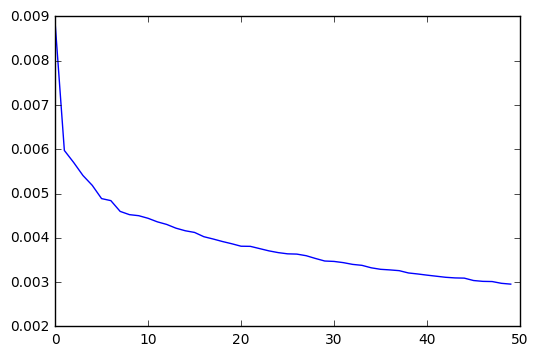

In [27]:
plt.plot(var)

### as we can see below, we need 19 components to explain 50% of the total variance

[ 0.04521169  0.07563649  0.10468024  0.13222518  0.15863732  0.18352713
  0.2081817   0.23159811  0.25464006  0.2775619   0.30018537  0.32240079
  0.34431974  0.36580749  0.38699734  0.40799427  0.42850063  0.44874214
  0.46869497  0.48839187  0.50780387  0.52720079  0.54633749  0.56521405
  0.58388996  0.60242693  0.62093239  0.63925413  0.65725757  0.67496761
  0.69263057  0.71015448  0.72747652  0.74468938  0.76161819  0.7783746
  0.79506256  0.81166457  0.82800115  0.8442208   0.86030561  0.87626798
  0.8921064   0.9078739   0.92361657  0.93908314  0.95445358  0.96980315
  0.98494867  1.        ]


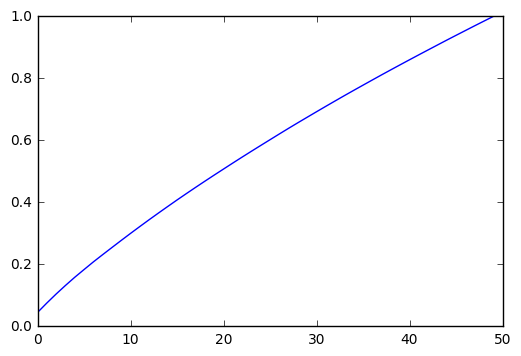

In [28]:
print(np.cumsum(var)/np.sum(var))
plt.plot(np.cumsum(var)/np.sum(var))

### Identifying important words in each of the principle components after filtering out stop words  and using TF-IDF

In [29]:
### part c: 
part_c(idf_pca_model, cv_fw_model)

0 ['2008', 'isbn', 'press', '24', 'pp', 'networked', 'x']
1 ['based', 'model', 'networks', 'wireless']
2 ['based', 'networks', 'wireless']
3 ['using', 'systems', 'networks']
4 ['systems', 'system', 'networks', 'information', 'data', 'time', 'real']
5 ['system', 'data', 'multi', 'software']
6 ['using', 'system', 'data', 'time']
7 ['systems', 'data', 'time', 'multi', 'web']
8 ['using', 'systems', 'system', 'analysis', 'information', 'performance', 'software', 'web']
9 ['model', 'analysis', 'data', 'performance', 'web']
10 ['model', 'study', 'case', 'object', 'oriented']
11 ['analysis', 'algorithm', 'problem', 'language']
12 ['based', 'using', 'model', 'information', 'data', 'time']
13 ['data', 'problem']
14 ['using', 'multi', 'network', 'learning']
15 ['network', 'error']
16 ['design', 'performance', 'language']
17 ['design', 'problem']
18 ['learning', '3']
19 ['system', 'multi', 'network']
20 ['video', 'estimation', 'channel']
21 ['analysis', 'recognition', 'language', 'error', '2009']


## Scatter plot of count vectorizer results after removing stop words

TF-IDF looks less structured than the scatter plot after applying the count vectorizer after removing stop words the and we only see one group and is not able to seperate groups as effectively

the results change such that is looks like all points form one community

Two components capture 7.5% of the variance which means that there are nearly no grouping and structure because less data is closer to the mean which means data points are more close to each other. 


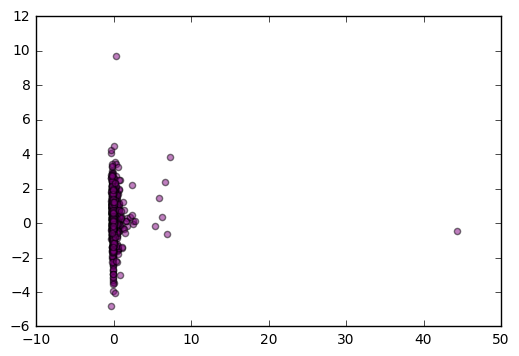

In [30]:
plot_scatter(tfResult, ic="tfidFeatures")

## VLDB vs NIPS

In [53]:
titles_VLDB = sc.textFile("VLDB_titles.txt").map(lambda l: (0, l.lower()))
titles_NIPS = sc.textFile("NIPS_titles.txt").map(lambda l: (1, l.lower()))

titles_VLDB_df = titles_VLDB.toDF()
titles_NIPS_df = titles_NIPS.toDF()

titles_VLDB_df.show()
titles_NIPS_df.show()

titles_NIPS_VLDB_df = titles_VLDB_df.unionAll(titles_NIPS_df)
titles_NIPS_VLDB_df.show()

+---+--------------------+
| _1|                  _2|
+---+--------------------+
|  0|automated selecti...|
|  0|fix: feature-base...|
|  0|an interval class...|
|  0|composite subset ...|
|  0|data sharing anal...|
|  0|the worlinfo assi...|
|  0|xml full-text sea...|
|  0|supporting except...|
|  0|direct algorithms...|
|  0|analyzing quantit...|
|  0|using formal meth...|
|  0|efficient increme...|
|  0|improving perform...|
|  0|analyzing energy ...|
|  0|an empirical perf...|
|  0|picodbms: validat...|
|  0|memory requiremen...|
|  0|management of sch...|
|  0|user-optimizer co...|
|  0|improving adaptab...|
+---+--------------------+
only showing top 20 rows

+---+--------------------+
| _1|                  _2|
+---+--------------------+
|  1|synchronized audi...|
|  1|cam storage of an...|
|  1|gradient descent ...|
|  1|synchronization a...|
|  1|grammatical infer...|
|  1|bayesian models o...|
|  1|breaking svm comp...|
|  1|learning to find ...|
|  1|reinforcement lea...|
| 

In [54]:
df_titles_NIPS_VLDB_rdd_full = regexTokenizer.transform(titles_NIPS_VLDB_df)
df_titles_NIPS_VLDB_rdd_full.show()

+---+--------------------+--------------------+
| _1|                  _2|               words|
+---+--------------------+--------------------+
|  0|automated selecti...|[automated, selec...|
|  0|fix: feature-base...|[fix, feature, ba...|
|  0|an interval class...|[an, interval, cl...|
|  0|composite subset ...|[composite, subse...|
|  0|data sharing anal...|[data, sharing, a...|
|  0|the worlinfo assi...|[the, worlinfo, a...|
|  0|xml full-text sea...|[xml, full, text,...|
|  0|supporting except...|[supporting, exce...|
|  0|direct algorithms...|[direct, algorith...|
|  0|analyzing quantit...|[analyzing, quant...|
|  0|using formal meth...|[using, formal, m...|
|  0|efficient increme...|[efficient, incre...|
|  0|improving perform...|[improving, perfo...|
|  0|analyzing energy ...|[analyzing, energ...|
|  0|an empirical perf...|[an, empirical, p...|
|  0|picodbms: validat...|[picodbms, valida...|
|  0|memory requiremen...|[memory, requirem...|
|  0|management of sch...|[management, o

In [55]:
filtered_df_N_D = remove_stop_words(df_titles_NIPS_VLDB_rdd_full)
# filtered_df_N_D.show()

In [56]:
(cv_result_filtered, cv_model_filtered) = apply_count_vectorizer(filtered_df_N_D, ic="filtered")  
cv_result_filtered.show(truncate=True)

+---+--------------------+--------------------+--------------------+--------------------+
| _1|                  _2|               words|            filtered|            features|
+---+--------------------+--------------------+--------------------+--------------------+
|  0|automated selecti...|[automated, selec...|[automated, selec...|(1000,[12,76,177,...|
|  0|fix: feature-base...|[fix, feature, ba...|[fix, feature, ba...|(1000,[8,45,66,15...|
|  0|an interval class...|[an, interval, cl...|[interval, classi...|(1000,[6,77,104,3...|
|  0|composite subset ...|[composite, subse...|[composite, subse...|(1000,[521,864],[...|
|  0|data sharing anal...|[data, sharing, a...|[data, sharing, a...|(1000,[1,6,14,48,...|
|  0|the worlinfo assi...|[the, worlinfo, a...|[worlinfo, assist...|(1000,[9,54,71,14...|
|  0|xml full-text sea...|[xml, full, text,...|[xml, full, text,...|(1000,[42,45,225,...|
|  0|supporting except...|[supporting, exce...|[supporting, exce...|(1000,[134,285,28...|
|  0|direc

In [57]:
pca_result_3, pca_model_3 = apply_pca(cv_result_filtered)
pca_result_3.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| _1|                  _2|               words|            filtered|            features|         pcaFeatures|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|automated selecti...|[automated, selec...|[automated, selec...|(1000,[12,76,177,...|[0.05826037023371...|
|  0|fix: feature-base...|[fix, feature, ba...|[fix, feature, ba...|(1000,[8,45,66,15...|[0.03113910898738...|
|  0|an interval class...|[an, interval, cl...|[interval, classi...|(1000,[6,77,104,3...|[0.12880175959193...|
|  0|composite subset ...|[composite, subse...|[composite, subse...|(1000,[521,864],[...|[1.79958924035264...|
|  0|data sharing anal...|[data, sharing, a...|[data, sharing, a...|(1000,[1,6,14,48,...|[0.50510408604954...|
|  0|the worlinfo assi...|[the, worlinfo, a...|[worlinfo, assist...|(1000,[9,54,71,14...|[0.07798698877054...|
|

In [58]:
var = pca_model_3.explainedVariance
print(var)
np.shape(var)

[0.0285038272492,0.0231072178046,0.0188137207774,0.0141057507147,0.0122732972317,0.0117005014416,0.0113643857273,0.00988202908977,0.0092378629719,0.00873275730672,0.00802707525435,0.0072996940428,0.00708419876893,0.00677759172975,0.00647956574535,0.00638506562874,0.00616918209809,0.00612331936439,0.00590812519933,0.00573318274767,0.00565685463919,0.00549922668047,0.0053667181591,0.00525521780281,0.0051585468172,0.00505828945451,0.00491778783089,0.00486727887525,0.00467755447304,0.00456209185389,0.00449510132445,0.0044843023133,0.00443212736599,0.00431646641373,0.00424438338957,0.00420522024029,0.00415377497243,0.00411042346568,0.00406512487671,0.00397514004196,0.00392279955261,0.00387439323075,0.00385506044372,0.00383500103143,0.00376034164492,0.00372511806534,0.00366527801051,0.00360561716678,0.00357184382604,0.00354856866559]


(50,)

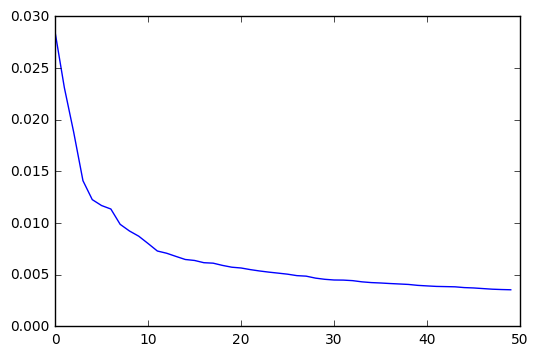

In [59]:
plt.plot(var)

### as we can see below, we need 13 components to explain 50% of the total variance 

[ 0.08272193  0.14978218  0.20438212  0.2453189   0.28093766  0.31489408
  0.34787506  0.37655403  0.40336355  0.42870718  0.45200283  0.47318752
  0.49374682  0.5134163   0.53222087  0.55075119  0.56865498  0.58642568
  0.60357185  0.62021031  0.63662727  0.65258676  0.6681617   0.68341304
  0.69838384  0.71306367  0.72733575  0.74146125  0.75503614  0.76827594
  0.78132133  0.79433538  0.80719801  0.81972497  0.83204274  0.84424685
  0.85630167  0.86823067  0.88002821  0.89156459  0.90294909  0.91419309
  0.925381    0.93651069  0.9474237   0.95823449  0.96887162  0.97933561
  0.98970158  1.        ]


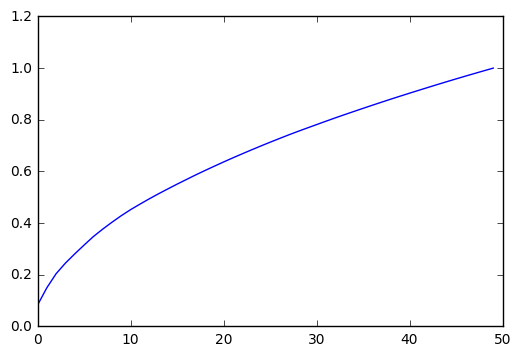

In [60]:
print(np.cumsum(var)/np.sum(var))
plt.plot(np.cumsum(var)/np.sum(var))

### Identifying important words in each of the principle components after filtering out stop words  and using count vectorizer

In [61]:
part_c(pca_model_3, cv_model_filtered)

0 ['learning', 'data']
1 ['learning', 'data', 'neural']
2 ['data', 'neural', 'networks']
3 ['using', 'networks', 'database', 'information', 'systems', 'processing']
4 ['using', 'database', 'systems']
5 ['networks', 'model']
6 ['networks', 'model', 'database', 'models', 'information', 'processing']
7 ['database', 'models', 'based']
8 ['model', 'models', 'based', 'network']
9 ['neural', 'networks', 'based', 'information', 'network']
10 ['models', 'databases', 'analysis', 'query', 'relational', 'object']
11 ['information', 'systems', 'system', 'databases', 'large']
12 ['information', 'databases', 'large', 'processing', 'query', 'optimization']
13 ['analysis', 'query']
14 ['system', 'databases', 'analysis', 'large', 'multi', 'approach', 'classification', 'scale']
15 ['large', 'multi', 'classification']
16 ['efficient', 'bayesian', 'query', 'time']
17 ['system', 'efficient', 'query', 'time', 'optimization', 'recognition', 'gaussian']
18 ['information', 'systems', 'bayesian', 'approach', 'in

### Applying TF-IDF

In [62]:
tfid_result, tfid_model = apply_tf_idf(cv_result_filtered)

In [63]:
tfid_result.show(truncate=True)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| _1|                  _2|               words|            filtered|            features|        tfidFeatures|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|automated selecti...|[automated, selec...|[automated, selec...|(1000,[12,76,177,...|(1000,[12,76,177,...|
|  0|fix: feature-base...|[fix, feature, ba...|[fix, feature, ba...|(1000,[8,45,66,15...|(1000,[8,45,66,15...|
|  0|an interval class...|[an, interval, cl...|[interval, classi...|(1000,[6,77,104,3...|(1000,[6,77,104,3...|
|  0|composite subset ...|[composite, subse...|[composite, subse...|(1000,[521,864],[...|(1000,[521,864],[...|
|  0|data sharing anal...|[data, sharing, a...|[data, sharing, a...|(1000,[1,6,14,48,...|(1000,[1,6,14,48,...|
|  0|the worlinfo assi...|[the, worlinfo, a...|[worlinfo, assist...|(1000,[9,54,71,14...|(1000,[9,54,71,14...|
|

In [64]:
pca_result_5, pca_model_5 = apply_pca(tfid_result, ic="tfidFeatures")
pca_result_5.select(["_1", "pcaFeatures"]).show()

+---+--------------------+
| _1|         pcaFeatures|
+---+--------------------+
|  0|[-0.0980147251708...|
|  0|[-0.0596260339104...|
|  0|[0.21356856989908...|
|  0|[-0.0332658071940...|
|  0|[0.06893269829301...|
|  0|[1.36990026063397...|
|  0|[-0.0016858081384...|
|  0|[-6.9026738184319...|
|  0|[0.11562547546332...|
|  0|[-0.0766269175555...|
|  0|[-0.0965160406642...|
|  0|[1.52064981472024...|
|  0|[-0.0698049974692...|
|  0|[-0.0040608454273...|
|  0|[0.42534108895059...|
|  0|[-6.6392525989840...|
|  0|[0.12961488113574...|
|  0|[0.16023455175786...|
|  0|[-0.0324660664299...|
|  0|[1.50622897342175...|
+---+--------------------+
only showing top 20 rows



In [65]:
var = pca_model_5.explainedVariance
print(var)
np.shape(var)

[0.00918035940695,0.00760503990458,0.00597240754182,0.00546044056071,0.00503483974013,0.00494797653594,0.00480485375476,0.00448693504819,0.00431958725367,0.00426355068116,0.00413169678609,0.00411714763841,0.00409103016443,0.00396231070647,0.00395079806126,0.00388419217303,0.00383614471065,0.00378519433723,0.00372591985764,0.00367787427298,0.00359944312979,0.00350215610385,0.003496740909,0.00342861761214,0.00340077541423,0.00336040884747,0.0033182390919,0.00324442808616,0.00322755533069,0.00321220357739,0.00317986912147,0.00316732092366,0.00313837842327,0.00308820579548,0.00305748609563,0.00301162021305,0.00299531626523,0.00297216406295,0.00293465955172,0.00292757063543,0.0029112833439,0.00288114836957,0.00287374018053,0.00283695401954,0.0028244670335,0.00280269489371,0.0027923800157,0.00278398589564,0.00273409035627,0.00271447653551]


(50,)

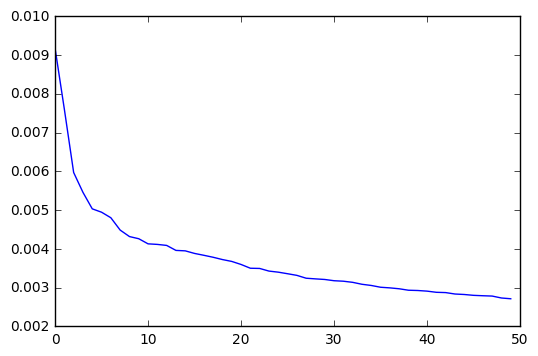

In [66]:
plt.plot(var)

### as we can see below, we need 19 components to explain 50% of the total variance 

[ 0.04892104  0.08944739  0.12127363  0.15037167  0.17720172  0.2035689
  0.22917339  0.25308373  0.2761023   0.29882225  0.32083956  0.34277935
  0.36457996  0.38569464  0.40674797  0.42744637  0.44788872  0.46805957
  0.48791455  0.50751351  0.52669451  0.54535708  0.56399079  0.58226149
  0.60038381  0.61829103  0.63597353  0.6532627   0.67046195  0.6875794
  0.70452454  0.72140282  0.73812686  0.75458354  0.77087652  0.78692508
  0.80288677  0.81872507  0.83436352  0.8499642   0.86547808  0.88083137
  0.89614519  0.91126298  0.92631423  0.94124945  0.95612971  0.97096524
  0.98553488  1.        ]


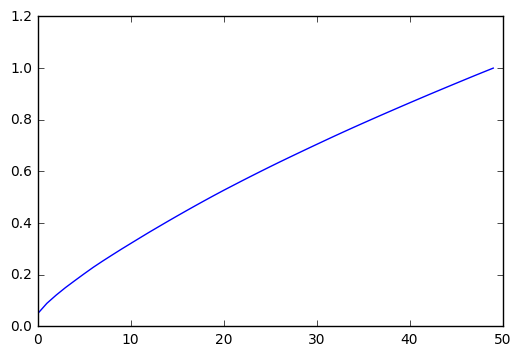

In [67]:
print(np.cumsum(var)/np.sum(var))
plt.plot(np.cumsum(var)/np.sum(var))

### Identifying important words in each of the principle components after filtering out stop words  and using TF-IDF

In [68]:
part_c(pca_model_5, cv_model_filtered)

0 ['neural', 'information', 'systems', 'processing', 'advances', 'december']
1 ['learning', 'data', 'neural', 'networks', 'database', 'system']
2 ['learning', 'neural', 'networks', 'network']
3 ['data', 'database', 'base']
4 ['learning', 'database', 'systems', 'reinforcement']
5 ['learning', 'database', 'models', 'based', 'gaussian']
6 ['networks', 'model', 'recognition', 'object', 'visual']
7 ['using', 'models', 'support', 'vector', 'machines']
8 ['using', 'model']
9 ['using', 'databases', 'large', 'object', 'scale']
10 ['using', 'model', 'based', 'analysis', 'gaussian', 'support', 'vector']
11 ['using', 'models', 'based', 'network']
12 ['analysis', 'multi', 'time', 'high', 'support', 'vector', 'dimensional']
13 ['model', 'system', 'large', 'multi', 'recognition']
14 ['models', 'based', 'query', 'optimization', 'gaussian', 'processes']
15 ['networks', 'efficient', 'large', 'query', 'time', 'high', 'dimensional', 'real']
16 ['analysis', 'query', 'time', 'gaussian', 'process']
17 ['netw

### Scatter plot comparision count vectorizer TF-IDF

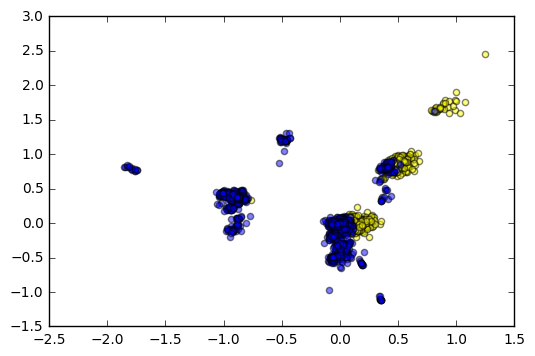

In [69]:
pca_result_4, pca_model_4 = apply_pca(cv_result_filtered, reduced_dim=2)

pca_features_vldb = pca_result_4.select("_1", "pcaFeatures").rdd.filter(lambda r: r[0] == 0)
pca_features_nips = pca_result_4.select("_1", "pcaFeatures").rdd.filter(lambda r: r[0] == 1)

x_0 = pca_features_vldb.map(lambda l: l[1][0]).collect()
y_0 = pca_features_vldb.map(lambda l: l[1][1]).collect()

x_1 = pca_features_nips.map(lambda l: l[1][0]).collect()
y_1 = pca_features_nips.map(lambda l: l[1][1]).collect()

### vldb
plt.scatter(x=x_0,y=y_0, c=['yellow'], alpha=0.5)

### nips
plt.scatter(x=x_1,y=y_1, c=['blue'], alpha=0.5)



In [70]:
pca_result_6, pca_model_6 = apply_pca(tfid_result, ic="tfidFeatures", reduced_dim=2)

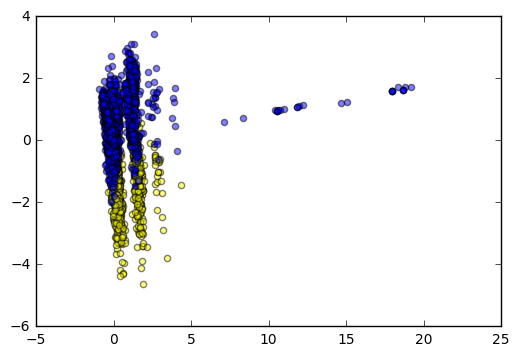

In [71]:

pca_features_vldb = pca_result_6.select("_1", "pcaFeatures").rdd.filter(lambda r: r[0] == 0)
pca_features_nips = pca_result_6.select("_1", "pcaFeatures").rdd.filter(lambda r: r[0] == 1)

x_0 = pca_features_vldb.map(lambda l: l[1][0]).collect()
y_0 = pca_features_vldb.map(lambda l: l[1][1]).collect()

x_1 = pca_features_nips.map(lambda l: l[1][0]).collect()
y_1 = pca_features_nips.map(lambda l: l[1][1]).collect()

### vldb
plt.scatter(x=x_0,y=y_0, c=['yellow'], alpha=0.5)
### nips 
plt.scatter(x=x_1,y=y_1, c=['blue'], alpha=0.5)



### comparing TF-IDF to CountVectorizer after removing stop words: 

CountVectorizer scatter plot is more structured than TF-IDF which means it is seperating the communities in a better way. 
Patterns in communities are recognized better by Count vectors. 

Also the variance captured by two components is 15% in count vectorizer and 8% in TF-IDF which means count vectorizer captures more variance which means it captures grouping more effectively 


### Did PCA succeed in uncovering differences between communities: 

PCA was able to uncover differences between academic communities in some sense when using count vectorizer however the points for each of the communties overlap because different communities can use the same words in the same degree of importance and PCA is not very good in identifying the use of words in different contexts
